### Задача: предсказать рейтинг шоколадного батончика.  
Данные:
    
   Bar id (**bar_id**) — ID батончика в базе данных  
   Company (Maker-if known) (**company**) — название компании, изготовившей батончик.  
   Specific Bean Origin or Bar Name (**specific_origin**) — точное место происхождения какао-бобов.  
   Broad Bean Origin (**broad_origin**) — название региона, где были выращены какао-бобы.  
    Company Location (**company_location**) — страна, в которой произведён шоколадный батончик.  
    Bean Type (**bean_type**) — вид какао-бобов, используемых в батончике.  
    REF (**ref**) — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.  
    Review Date (**review_date**) — год публикации рецензии.   
    Cocoa Percent (**cocoa_percent**) — процент какао в шоколаде.  
    Rating (**rating**) — оценка батончика фокус-группой. (целевая переменная)  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
RANDOM_STATE = 23

## 1 EDA

In [3]:
DATA_PATH = 'data/'

In [4]:
# Прочитаем данные, и для удобства работы переименуем колонки
df_raw = pd.read_csv((DATA_PATH + 'cacao_flavors.csv'))
df_raw.columns = ['bar_id', 'company', 'specific_origin', 'ref', 'review_date', 'cocoa_percent', 'company_location',
             'rating', 'bean_type', 'broad_origin']
# Сохраним оригинальный датасет в переменной df_raw, в дальнейшем для работы будем использовать df
df = df_raw.copy()

Посмотрим на данные: у нас всего 1795 записей. Судя по df.info(), пропусков практически нет, однако взгляд на непостредственную таблицу (df.head()) показывает, что много пропусков в виде пробелов.  


In [5]:
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bar_id            1795 non-null   int64  
 1   company           1795 non-null   object 
 2   specific_origin   1795 non-null   object 
 3   ref               1795 non-null   int64  
 4   review_date       1795 non-null   int64  
 5   cocoa_percent     1795 non-null   object 
 6   company_location  1795 non-null   object 
 7   rating            1795 non-null   float64
 8   bean_type         1794 non-null   object 
 9   broad_origin      1794 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 140.4+ KB


None

,bar_id,company,specific_origin,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_origin
0,1,A. Morin,Agua Grande,1876,2016,63%,France,11.50,,Sao Tome
1,2,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,3,A. Morin,Atsane,1676,2015,670%,France,3.00,,Togo
3,4,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,5,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
5,6,A. Morin,Carenero,1315,2014,70%,France,2.75,Criollo,Venezuela
6,7,A. Morin,Cuba,1315,2014,70%,France,3.50,,Cuba
7,8,A. Morin,Sur del Lago,1315,2014,70%,France,11.50,Criollo,Venezuela
8,9,,Puerto Cabello,1319,2014,70%,France,3.75,Criollo,Venezuela
9,10,A. Morin,Pablino,1319,2014,70%,France,4.00,,Peru


### 1.1 Работа с числовыми столбцами  
Числовые столбцы (и те, которые могут быть к ним приведены):  
**bar_id**  
**cocoa_percent**  
**ref**  
**review_date**  
**rating**

In [6]:
# удалим столбец bar_id - это порядковый номер баточика в базе, он не несет полезной информации
df.drop('bar_id', axis = 1, inplace = True)

In [7]:
df.cocoa_percent = df_raw.cocoa_percent

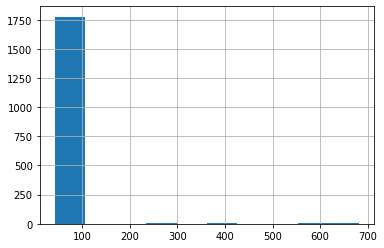

In [8]:
# Переведем в числовой тип значения в cocoa_percent и посмотрим на них:
df.cocoa_percent = df.cocoa_percent.apply(lambda x: x[:-1]).astype(float)
df.cocoa_percent.hist()

In [9]:
# Какие значения чаще всего встречаются?
df.cocoa_percent.value_counts().head(5)

70.0    664
75.0    219
72.0    189
65.0     77
80.0     70
Name: cocoa_percent, dtype: int64

In [10]:
# видим, что есть выбросы - содержание какао больше 100%.
display(df.cocoa_percent.loc[df.cocoa_percent > 100])
# заметим, что если отбросить первую цифру, то две последних (70%, 75%, 80%) - соотвествтуют наиболее частым значениям содержания какао.
# не будем удалять эти выбросы, а удалим первую цифру:
df.cocoa_percent = df.cocoa_percent.apply(lambda x: float(str(x)[1:]) if x > 100  else x)

2       670.0
203     475.0
220     270.0
400     580.0
522     470.0
540     576.0
581     270.0
741     582.0
827     570.0
1139    265.0
1154    270.0
1158    668.0
1167    670.0
1178    571.0
1216    375.0
1383    270.0
1439    682.0
1561    380.0
1785    375.0
Name: cocoa_percent, dtype: float64

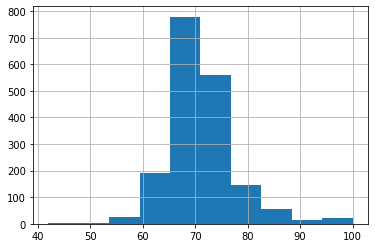

In [11]:
# Посмотрим на получившееся распределение:
df.cocoa_percent.hist()

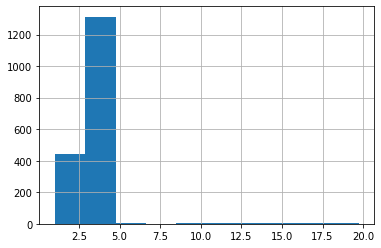

In [12]:
# Целевая переменная
df.rating.hist()

In [13]:
# Судя по всему, использовалась 5-ти балльная шкала оценки. Но есть выбросы (38 шт)
display(df.rating.loc[df.rating > 5])
# Сложно предположить, в чем причина выбросов в целевой переменной, просто удалим их
df = df[df.rating <= 5]

0       11.50
7       11.50
81      19.00
94      12.50
104     18.50
115     10.00
153     10.25
223     17.25
294     11.50
315     18.25
431     15.50
432     19.75
468     15.75
537     19.25
586     12.50
594     13.75
644     11.00
695     16.75
698     17.25
841     12.50
845     15.50
886     11.75
931     17.75
939     10.00
989     10.50
997     15.75
1115    10.75
1166    12.50
1232    19.00
1371    14.25
1379    12.00
1386    15.75
1493    10.00
1495    18.50
1659    12.50
1692    19.00
1709    13.75
1727    15.50
Name: rating, dtype: float64

Остаются два числовых столбца: ref и review_date. Судя по их гистрограммам, данные распределены равномерно, выбросов нет, пропусков тоже
*что можно улучшить: нарисовать гистограммы красиво, в одной ячейке, со всеми подписями - чтобы одном взглядом увидеть все числовые*

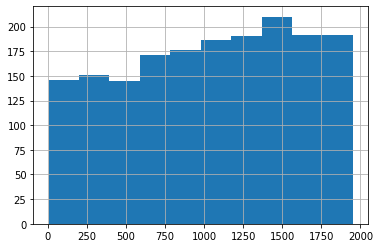

In [14]:
df.ref.hist()

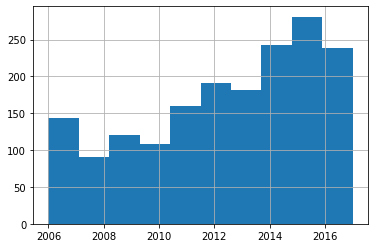

In [15]:
df.review_date.hist()

In [16]:
df.ref.isna().sum(), df.review_date.isna().sum()

(0, 0)

In [17]:
df.ref.nunique(), df.review_date.nunique()

(440, 12)

In [18]:
# Посмотрим на корреляцию между числовыми переменными. Видим высокую корреляцию между ref и review_date. 
display(df.corr())
# удалим review_date, потому что в нем меньшe разброс числовых значений
df.drop('review_date', axis = 1, inplace=True)

,ref,review_date,cocoa_percent,rating
ref,1.000000,0.985050,0.037326,0.096522
review_date,0.985050,1.000000,0.038246,0.094666
cocoa_percent,0.037326,0.038246,1.000000,-0.165905
rating,0.096522,0.094666,-0.165905,1.000000


### 1.2 Работа с категориальными переменными  
Остаются следующие категориальные переменные:  
**company** — название компании, изготовившей батончик.  
**specific_origin** — точное место происхождения какао-бобов.  
**broad_origin** — название региона, где были выращены какао-бобы.  
**company_location** — страна, в которой произведён шоколадный батончик.  
**bean_type** — вид какао-бобов, используемых в батончике.  



In [19]:
# Посмотрим на наименование фирмы-изготовителя. Видим, что у нас 403 уникальных наименования
# среди них есть пропуск, записанный как '\xa0'. Заменим его на честный NaN
display(df.company.unique())
df.company = df.company.apply(lambda x: None if x.strip == '' or x == '\xa0' else x)

array(['A. Morin', '\xa0', 'Acalli', 'Adi', 'Aequare (Gianduja)',
       'Ah Cacao', "Akesson's (Pralus)", 'Alain Ducasse', 'Alexandre',
       'Altus aka Cao Artisan', 'Amano', 'Amatller (Simon Coll)',
       'Amazona', 'Ambrosia', 'Amedei', 'AMMA', 'Anahata', 'Ara', 'Arete',
       'Artisan du Chocolat', 'Artisan du Chocolat (Casa Luker)',
       'Askinosie', 'Bahen & Co.', 'Bakau', 'Bar Au Chocolat',
       "Baravelli's", 'Batch', 'Beau Cacao', 'Beehive', 'Belcolade',
       'Bellflower', 'Belyzium', 'Benoit Nihant', 'Bernachon',
       'Beschle (Felchlin)', 'Bisou', 'Bittersweet Origins',
       'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
       'Blue Bandana', 'Bonnat', 'Bouga Cacao (Tulicorp)', 'Bowler Man',
       "Brasstown aka It's Chocolate", 'Brazen', 'Breeze Mill', 'Bright',
       'Britarev', 'Bronx Grrl Chocolate', 'Burnt Fork Bend',
       'Cacao Arabuco', 'Cacao Atlanta', 'Cacao Barry', 'Cacao de Origen',
       'Cacao de Origin', 'Cacao Hunters', 'Cacao Mar

In [20]:
df.company.isna().sum()

99

Видим, что у нас 402 уникальных значения и 99 пропусков. Кажется, что в таком виде эти данные не будут полезными для модели, поэтому для первого варианта удалим этот столбец.

In [21]:
df.drop('company', axis=1, inplace=True)

In [22]:
# Столбец specific_origin - точный регион происхождения какао-бобов
# 
df.specific_origin.nunique()

995

In [23]:
df.specific_origin = df.specific_origin.apply(lambda x: None if x.strip == '' or x == '\xa0' else x)

In [24]:
df.specific_origin.isna().sum()

56

В столбце specific_origin 995 уникальных значений и 56 пропусков. Удалим его, в таком виде информации недостаточно для предсказания рейтинга

In [25]:
df.drop('specific_origin', axis=1, inplace=True)

In [26]:
# В информации по странам происхожнения бобов 98 уникальных значений. 
# Видим, что во-1, есть различные написания одной и той же страны
# во-2, есть батончики, где указано несколько стран происхождения

print('Уникальных значений в стране происхождения бобов: ', df.broad_origin.nunique())
df.broad_origin.unique()

Уникальных значений в стране происхождения бобов:  98


array(['Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama', 'Madagascar',
       'Brazil', 'Ecuador', 'Colombia', 'Burma', 'Papua New Guinea',
       'Bolivia', 'Fiji', 'Mexico', 'Indonesia', 'Trinidad', 'Vietnam',
       'Nicaragua', 'Tanzania', 'Dominican Republic', 'Ghana', 'Belize',
       '\xa0', 'Jamaica', 'Honduras', 'Costa Rica', 'Guatemala', 'Haiti',
       'Congo', 'Philippines', 'Domincan Republic', 'Malaysia',
       'Dominican Rep., Bali', 'Venez,Africa,Brasil,Peru,Mex', 'Gabon',
       'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico', 'Grenada',
       'Sao Tome', 'Uganda', 'Martinique', 'Sao Tome & Principe',
       'Vanuatu', 'Australia', 'Liberia', 'Ecuador, Costa Rica',
       'West Africa', 'Hawaii', 'St. Lucia', 'Cost Rica, Ven',
       'Peru, Madagascar', 'Venezuela, Trinidad', 'Trinidad, Tobago',
       'Ven, Trinidad, Ecuador', 'South America, Africa', 'India',
       'Africa, Carribean, C. Am.', 'Trinidad-Tobago',
       'Peru, Ecuador, Venezuela', 'Venezuela, D

Обработаем эти данные следующим образом:  
1. Приведем к единообразному написанию все наименования стран
2. Приведем к единообразоному написанию (с разделителем ',') данные, где указано несколько стран
3. Преобразуем в dummies-переменные

In [27]:
# избавляемся от пропусков
df.broad_origin = df.broad_origin.astype(str).apply(lambda x: np.nan if x.strip() == '' else x)


# очистим данные по странам. Приведем в вид: уникальные названия стран, через запятую.
alias_dict = dict()
for alias in ['DR', 'Dom Rep', 'Domin Rep', 'Dominican Rep']:
    alias_dict[alias] = 'Domincan Republic'
for alias in ['Ven', 'Venez']:
    alias_dict[alias] = 'Venezuela'
for alias in ['PNG']:
    alias_dict[alias] = 'Papua New Guinea' 
for alias in ['Cost Rica']:
    alias_dict[alias] = 'Costa Rica'    
for alias in ['Mex']:
    alias_dict[alias] = 'Mexico'
alias_dict['Mad'] = 'Madagascar'
alias_dict['Principe'] = 'Sao Tome'
alias_dict['Gre'] = 'Grenada'
alias_dict['Haw'] = 'Hawaii'
alias_dict['Ecu'] = 'Ecuador'
alias_dict['Nic'] = 'Nicaragua'
alias_dict['Guat'] = 'Guatemala'

# функция для приведения перечня стран происхождения в единообразный вид:
def clean_countries(x):
    #удалим все точки от сокращений
    x = x.replace('.','')
    x = x.replace('-','')
    x = x.replace('/',',')
    x = x.replace(' & Principe', '') # приведем к одному виду страну Sao Tome
    x = x.replace('&', ',')
    if '(' in x: x = x[:x.find('(')]
    x = ','.join([_.strip() for _ in x.split(',')]) # разбиваем перечен стран по ','; удалаем пробелы по краям; соединяем снова через ','
    for alias in alias_dict.keys():
        if alias in x.split(','):
            x = x.replace(alias, alias_dict[alias])
    return x

df.broad_origin = df.broad_origin.astype(str).apply(clean_countries)

In [28]:
print('Уникальных значений в стране происхождения бобов: ', df.broad_origin.nunique())
df.broad_origin.unique()

Уникальных значений в стране происхождения бобов:  93


array(['Togo', 'Peru', 'Venezuela', 'Cuba', 'Panama', 'Madagascar',
       'Brazil', 'Ecuador', 'Colombia', 'Burma', 'Papua New Guinea',
       'Bolivia', 'Fiji', 'Mexico', 'Indonesia', 'Trinidad', 'Vietnam',
       'Nicaragua', 'Tanzania', 'Dominican Republic', 'Ghana', 'Belize',
       'nan', 'Jamaica', 'Honduras', 'Costa Rica', 'Guatemala', 'Haiti',
       'Congo', 'Philippines', 'Domincan Republic', 'Malaysia',
       'Domincan Republic,Bali', 'Venezuela,Africa,Brasil,Peru,Mexico',
       'Gabon', 'Ivory Coast', 'Carribean', 'Sri Lanka', 'Puerto Rico',
       'Grenada', 'Sao Tome', 'Uganda', 'Martinique', 'Vanuatu',
       'Australia', 'Liberia', 'Ecuador,Costa Rica', 'West Africa',
       'Hawaii', 'St Lucia', 'Costa Rica,Venezuela', 'Peru,Madagascar',
       'Venezuela,Trinidad', 'Trinidad,Tobago',
       'Venezuela,Trinidad,Ecuador', 'South America,Africa', 'India',
       'Africa,Carribean,C Am', 'TrinidadTobago',
       'Peru,Ecuador,Venezuela', 'Venezuela,Domincan Republic',


In [29]:
# составим список всех встречающихся стран
countri_set = set()
for x in df.broad_origin.unique():
    countri_set = countri_set.union(set(x.split(',')))
countries = list(countri_set)
countries.sort()
countries.remove('nan')
print(countries)

['Africa', 'Australia', 'Bali', 'Belize', 'Bolivia', 'Brasil', 'Brazil', 'Burma', 'C Am', 'Cameroon', 'Carribean', 'Central and S America', 'Colombia', 'Congo', 'Costa Rica', 'Cuba', 'Domincan Republic', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Fiji', 'Gabon', 'Ghana', 'Grenada', 'Guatemala', 'Haiti', 'Hawaii', 'Honduras', 'India', 'Indonesia', 'Ivory Coast', 'Jamaica', 'Java', 'Liberia', 'Madagascar', 'Malaysia', 'Martinique', 'Mexico', 'Nicaragua', 'Nigeria', 'Panama', 'Papua New Guinea', 'Peru', 'Philippines', 'Puerto Rico', 'Samoa', 'Sao Tome', 'Solomon Islands', 'South America', 'Sri Lanka', 'St Lucia', 'Suriname', 'Tanzania', 'Tobago', 'Togo', 'Trinidad', 'TrinidadTobago', 'Uganda', 'Vanuatu', 'Venezuela', 'Vietnam', 'West Africa']


In [30]:
# добавим dummy-variables, где 1 будет соответствовать стране происхождения бобов
for country in countries:
    df[country] = df.broad_origin.apply(lambda x: 1 if country in x.split(',') else 0)
df.drop('broad_origin', axis=1, inplace=True)

In [31]:
# Страна фирмы-изготовителя - -60 уникальных значений, пропусков нет
df.company_location.nunique(), df.company_location.isna().sum()

(60, 0)

In [32]:
df = df.join(pd.get_dummies(df.company_location, prefix='comp'))
df.drop('company_location', axis=1, inplace=True)

In [33]:
df

,ref,cocoa_percent,rating,bean_type,Africa,Australia,Bali,Belize,Bolivia,Brasil,...,comp_Spain,comp_St. Lucia,comp_Suriname,comp_Sweden,comp_Switzerland,comp_U.K.,comp_U.S.A.,comp_Venezuela,comp_Vietnam,comp_Wales
1,1676,70.0,2.75,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1676,70.0,3.00,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1680,70.0,3.50,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1704,70.0,3.50,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1315,70.0,2.75,Criollo,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,647,70.0,3.75,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,749,65.0,3.00,Forastero,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,749,65.0,3.50,Forastero,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793,781,62.0,3.25,,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# Уникальных типов шоколадных батончиков в исходном датасете - 41. 
# В то же время, почти половина значений - пропуски. Пока не будем использовать эти данные
df.bean_type = df.bean_type.astype(str).apply(lambda x: np.nan if x.strip() == '' else x)
df.bean_type.nunique(), df.bean_type.isna().sum()

(41, 869)

In [35]:
df.drop('bean_type', axis=1, inplace=True)

In [36]:
# Итоговый датасет
df

,ref,cocoa_percent,rating,Africa,Australia,Bali,Belize,Bolivia,Brasil,Brazil,...,comp_Spain,comp_St. Lucia,comp_Suriname,comp_Sweden,comp_Switzerland,comp_U.K.,comp_U.S.A.,comp_Venezuela,comp_Vietnam,comp_Wales
1,1676,70.0,2.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1676,70.0,3.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1680,70.0,3.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1704,70.0,3.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1315,70.0,2.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,647,70.0,3.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1791,749,65.0,3.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1792,749,65.0,3.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1793,781,62.0,3.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



## 2 Разбивка на трейн-тест  
*TODO: нужно разбить на 3 части, трейн, валидация, отложенная выборка: на валидации подбираем параметры модели, на отложенной - окончательный вывод о модели*

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('rating', axis=1), df.rating, 
                                                    random_state=RANDOM_STATE, test_size = 0.2)

In [38]:
# Как будем оценивать модель? возьмем для начала MAE
# Будем рассматривать эту задачу как зачаду регресии (можно также попробовать классификацию, но нужно уменшить шаг оценки хотя бы до 0.5)

## 3 Модель

### 3.1 RandomForestRegressor

In [39]:
# для начала посмотрим, какая будет средняя отностельная ошибка, если мы предскажем рейтинг = среднему рейтингу на тренировочной выборке
y_naive = y_train.mean() * np.ones(y_test.shape)

In [40]:
mean_absolute_error(y_test, y_naive) # то есть, модель должна существенно улучшить точность предсказания в 0.38

0.388748584600453

In [41]:
# для pipeline возьмем RangomForestRegressor  - хорошая модель, но можено еще CatBoost попробовать потом для улучшения
model = RandomForestRegressor(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_error(y_test, y_pred)
# Вывод: модель "по умолчению" не дает существенного улучшения метрики по сравнению с примитивной моделью

0.3594041475018037

In [42]:
## Воспользуемся лекцией о случайном лесе, попробуем оттуда перебор параметров:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [43]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [44]:
y_pred = rf_random.predict(X_test)
mean_absolute_error(y_test, y_pred)
# результат - MAE 0.355. Нельзя назвать хорошом, нужно разбираться, почему так

0.355733107765975

In [45]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

## Мои идеи для дальнейшей работы: 
0. Понять, почему случайный лес дал такой результат, может ли он быть улучшен, является ли эта модель подходящей для этой задачи?  
1. Попробовать другие модели-регрессоры: линейная регрессия, катбуст
2. Попробовать сделать классификацию, для этого понизить количество возможных оценок (например: 1, 2, 3, 3.5, 4, 5).
3. Для классификации взять те же самые катбуст, рандом форест, логрег.
4. Попробовать все предыдущие модели прогнать на еще двух датасетах: 1-самый простой, оставить минимум столбцов. 2 - "усложнить", поработать еще с данными, построить дополнительные фичи, и возможно, отбросить первоначальные фичи.
5. Ансамблирование моделей?
6. Нормирование признаков!


In [ ]:
9-8